In [1]:
import numpy as np
import matplotlib.pyplot as plt

import central_system as cs
import analyze_control as ac
import read_load as rl

# 検討ケース

In [2]:
case = {
    'region': 6,
    'a_mr': 29.81,
    'a_or': 51.34,
    'a_a': 120.08,
    'r_env': 2.95556,
    'insulation': 'h11',
    'solar_gain': 'middle',
    'default_heat_source_spec': True,
    'supply_air_rtd_h': 1800.0,
    'supply_air_rtd_c': 1800.0,
    'is_duct_insulated': True,
    'vav_system': False,
    'cap_rtd_h': 12000.0,
    'cap_rtd_c': 12000.0,
}

1日グラフを描画する日を指定する。

In [3]:
hday = '2/1'
cday = '9/1'

# 床面積

非居室の床面積 $A_{NR}$ は下式で表される。

$$ A_{NR} = A_A - A_{MR} - A_{OR}$$

$A_{NR}$：非居室の床面積, m<sup>2</sup>  
$A_A$：床面積の合計, m<sup>2</sup>  
$A_{MR}$：主たる居室の床面積, m<sup>2</sup>  
$A_{OR}$：その他の居室の床面積, m<sup>2</sup>  

In [4]:
a_nr = cs.get_non_occupant_room_floor_area(case['a_mr'], case['a_or'], case['a_a'], case['r_env'])
a_nr

38.92999999999999

標準住戸における暖冷房区画 $i$ の床面積 $A_{HCZ,R,i}$ 及び暖冷房区画 $i$ の床面積 $A_{HCZ,i}$ は第2章で計算される。 

## 標準住戸

In [5]:
a_hcz_r = cs.get_referenced_floor_area()
a_hcz_r

array([29.81, 16.56, 13.25, 10.76, 10.77,  3.31,  1.66,  3.31, 13.25,
        4.97, 10.77,  1.66])

## 当該住戸

In [6]:
a_hcz = cs.get_floor_area(case['a_mr'], case['a_or'], case['a_a'], case['r_env'])
a_hcz

array([29.81, 16.56, 13.25, 10.76, 10.77,  3.31,  1.66,  3.31, 13.25,
        4.97, 10.77,  1.66])

# 間仕切り

## 面積

暖冷房空間 $i$ ( $i=1$ ) (主たる居室) から見た非暖冷房空間の間仕切りの面積
$$ A_{prt,i} = A_{HCZ,i} r_{env} \frac{ A_{NR} }{ A_{OR} + A_{NR} } $$

暖冷房空間 $i$ ( $i=2,3,4,5$ ) (その他の居室) から見た非暖冷房空間の間仕切りの面積
$$ A_{prt,i} = A_{HCZ,i} r_{env} \frac{ A_{NR} }{ A_{MR} + A_{NR} } $$

$A_{prt,i}$：暖冷房区画 $i$ から見た非暖冷房空間の間仕切りの面積, m<sup>2</sup>  
$A_{HCZ,i}$：暖冷房区画 $i$ の床面積, m<sup>2</sup>  
$r_{env}$：床面積の合計に対する外皮の部位の面積の合計の比  
$A_{MR}$：主たる居室の床面積, m<sup>2</sup>  
$A_{OR}$：その他の居室の床面積, m<sup>2</sup>  
$A_{NR}$：非居室の床面積, m<sup>2</sup>  

In [7]:
a_part = cs.get_partition_area(a_hcz, case['a_mr'], case['a_or'], a_nr, case['r_env'])
a_part

array([37.99642332, 27.71883598, 22.17841647, 18.01054802, 18.02728644])

## 熱損失係数

間仕切りの熱貫流率 $U_{prt}$ は 1/0.46 とする

In [8]:
u_prt = cs.get_heat_loss_coefficient_of_partition()
u_prt

2.1739130434782608

# 外皮性能

本来これは入力値である。（この notebook では、説明を簡単にするため、断熱レベル・日射熱取得レベルで指定するようにしている。）

In [9]:
q, mu_h, mu_c = cs.get_envelope_spec(case['region'], case['insulation'], case['solar_gain'])

In [10]:
(q, mu_h, mu_c)

(2.7, 0.101, 0.062)

# 物性値

## 空気の密度

空気の密度 $\rho$ は 1.2 kg/m<sup>3</sup> とする。

In [11]:
rho = cs.get_air_density()
rho

1.2

## 空気の比熱

空気の比熱 $c$ は1006.0 J/kgK とする。

In [12]:
c = cs.get_specific_heat()
c

1006.0

# 外気条件

## 外気温度

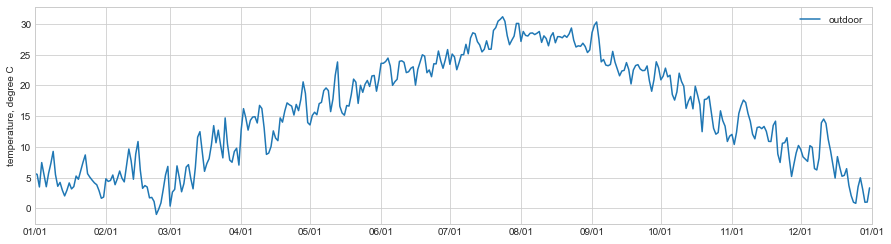

In [13]:
theta_ex = cs.get_outdoor_temperature(case['region'])
ac.draw_graph('temperature, degree C', [(theta_ex, 'outdoor')], 'ave')

## 水平面全天日射量

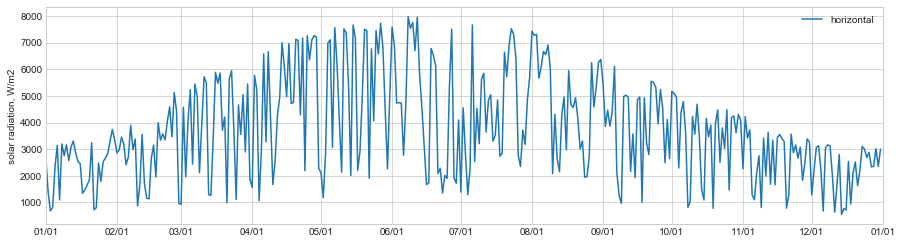

In [14]:
j = cs.get_horizontal_solar(case['region'])
ac.draw_graph('solar radiation, W/m2', [(j, 'horizontal')], 'itg')

## SAT 温度

$$ \theta_{SAT,d,t} = \theta_{ex,d,t} + 0.034 J_{d,t} $$

$\theta_{SAT,d,t}$：日付$d$の時刻$t$における水平面における等価外気温度, degree C  
$\theta_{ex,d,t}$：日付$d$の時刻$t$における外気温度, degree C  
$J_{d,t}$：日付$d$の時刻$t$における水平面全天日射量, W/m<sup>2</sup>

日付 $d$ の時刻 $t$ における水平面全天日射量 $J_{d,t}$ は、第11章「その他」第2節「日射に関する地域区分と日射量」付録A「傾斜面における単位面積当たりの平均日射量」A.2「傾斜面における単位面積当たりの平均日射量の計算方法」において、傾斜面の方位角 $P_\alpha$ を 0°、傾斜面の傾斜角 $P_\beta$ を0°として計算した日付 $d$ 時刻 $t$ における傾斜面の単位面積当たりの平均日射量 $I_{s,d,t}$ である。その際、日付 $d$ の時刻 $t$ における法線面直達日射量 $I_{DN,d,t}$ ・水平面全天日射量 $I_{Sky,d,t}$ ・太陽高度 $h_{d,t}$ ・太陽方位角 $A_{d,t}$ は、第11章「その他」第1節「地域の区分と外気条件」において、地域の区分に応じて定める値とする。

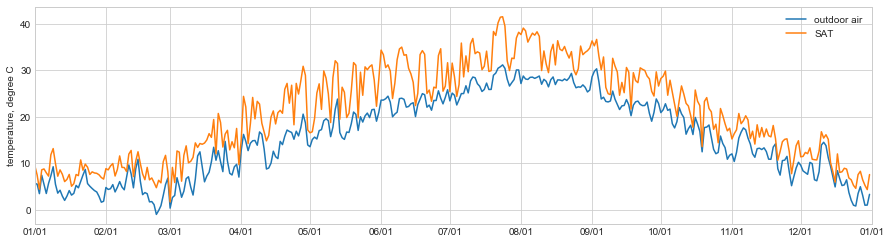

In [15]:
theta_sat = cs.get_sat_temperature(case['region'])
ac.draw_graph('temperature, degree C', [(theta_ex, 'outdoor air'), (theta_sat, 'SAT')], 'ave')

### 1日単位

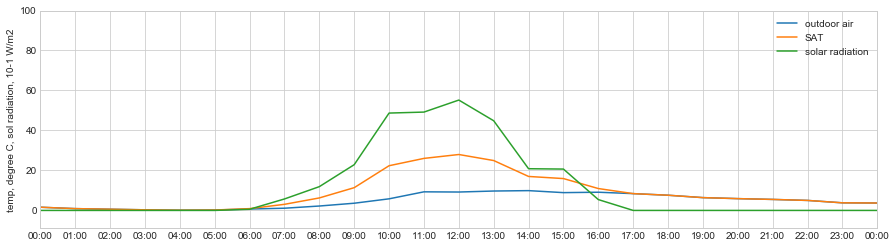

In [16]:
ac.draw_graph(y_title='temp, degree C, sol radiation, 10-1 W/m2',
              ys=[(theta_ex, 'outdoor air'), (theta_sat, 'SAT'), (j*10**(-1), 'solar radiation')],
              op='raw', display_date=hday)

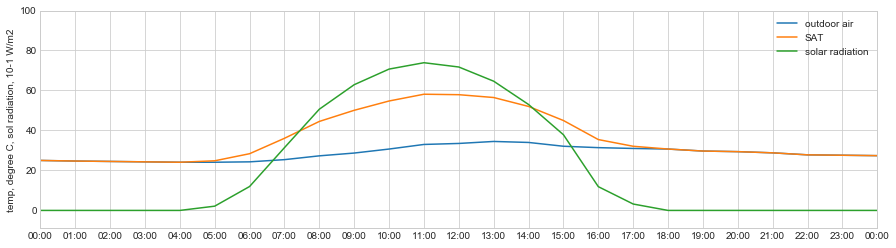

In [17]:
ac.draw_graph(y_title='temp, degree C, sol radiation, 10-1 W/m2',
              ys=[(theta_ex, 'outdoor air'), (theta_sat, 'SAT'), (j*10**(-1), 'solar radiation')],
              op='raw', display_date=cday)

## 年間

# 暖冷房負荷

室 $i$ の暖房負荷 $L_{H,d,t,i}$ 、顕熱冷房負荷 $L_{CS,d,t,i}$ 、潜熱冷房負荷 $L_{CL,d,t,i}$ は、主たる居室・その他の居室の床面積、床面積の合計、断熱性能、日射熱取得性能に応じて決定される。

In [18]:
l_h, l_cs, l_cl = cs.get_load(region=case['region'], insulation=case['insulation'], solar_gain=case['solar_gain'],
                  a_mr=case['a_mr'], a_or=case['a_or'], a_a=case['a_a'], r_env=case['r_env'])

今回使用する居室（room number 1 - 5）の負荷およびその合計、非居室を含めた全部屋の負荷（旧評価方法で使用。新評価方法では非居室の負荷は使用しない。）を描画する。

In [19]:
def make_list(load_data):

    return [(load_data[0], 'room 1'),
            (load_data[1], 'room 2'),
            (load_data[2], 'room 3'),
            (load_data[3], 'room 4'),
            (load_data[4], 'room 5'),
            (np.sum(load_data[0:5], axis=0), 'room 1-5'),
            (np.sum(load_data, axis=0), 'room 1-12')]

## 年間

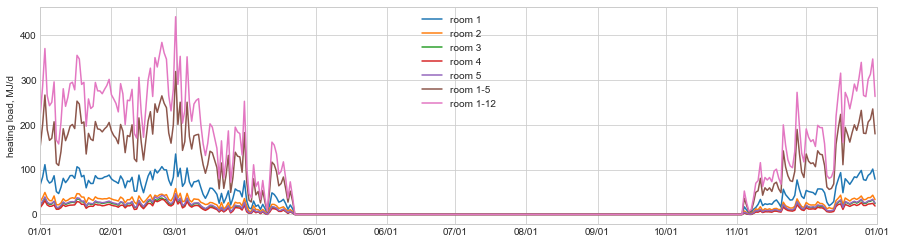

In [20]:
ac.draw_graph('heating load, MJ/d', make_list(l_h), 'itg')

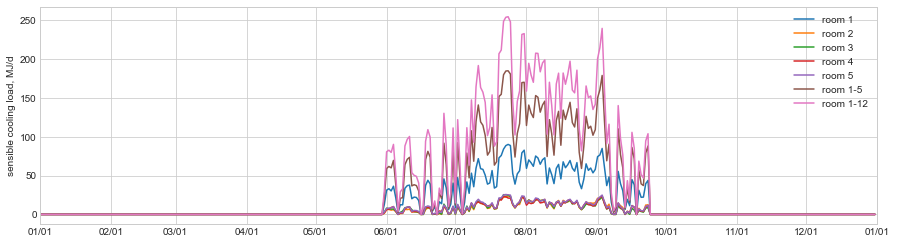

In [21]:
ac.draw_graph('sensible cooling load, MJ/d', make_list(l_cs), 'itg')

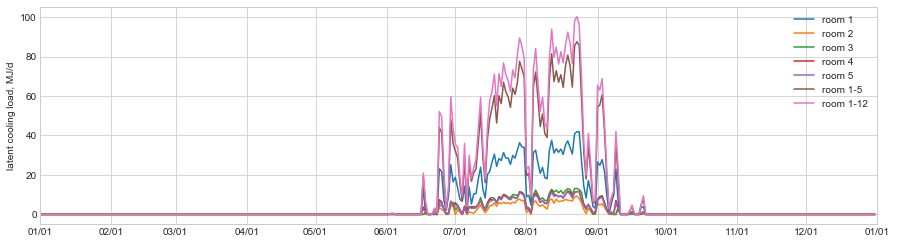

In [22]:
ac.draw_graph('latent cooling load, MJ/d', make_list(l_cl), 'itg')

## 1日単位

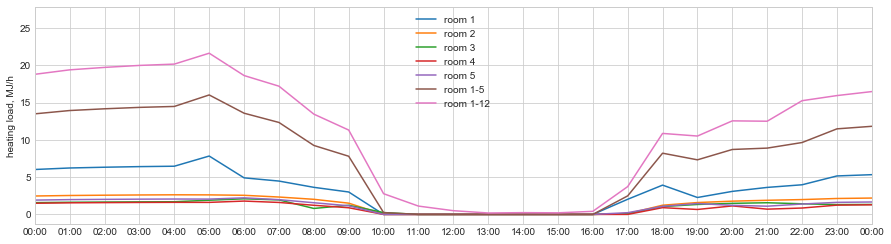

In [23]:
ac.draw_graph(y_title='heating load, MJ/h', ys=make_list(l_h), op='raw', display_date=hday)

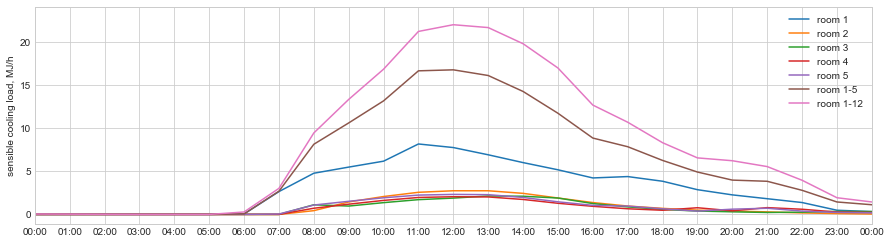

In [24]:
ac.draw_graph(y_title='sensible cooling load, MJ/h', ys=make_list(l_cs), op='raw', display_date=cday)

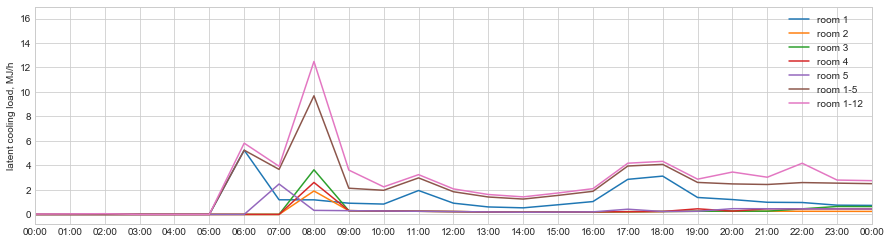

In [25]:
ac.draw_graph(y_title='latent cooling load, MJ/h', ys=make_list(l_cl), op='raw', display_date=cday)

# 設定温度

暖房時の暖冷房区画の温度 $\theta_{ac,H}$ は20℃、冷房時の暖冷房区画の温度 $\theta_{ac,C}$ は27℃とする。

In [26]:
theta_ac_h = cs.get_air_conditioned_temperature_for_heating()
theta_ac_c = cs.get_air_conditioned_temperature_for_cooling()

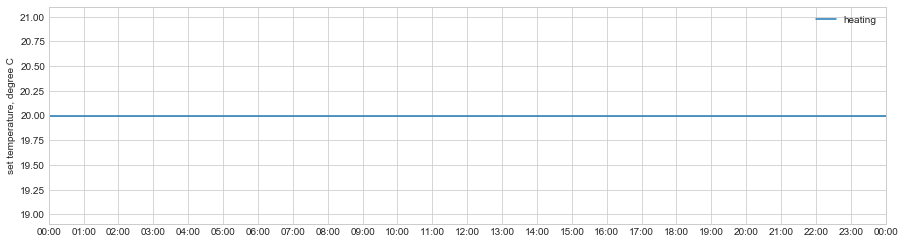

In [27]:
ac.draw_graph(y_title='set temperature, degree C', ys=[(theta_ac_h, 'heating')], op='raw', display_date=hday)

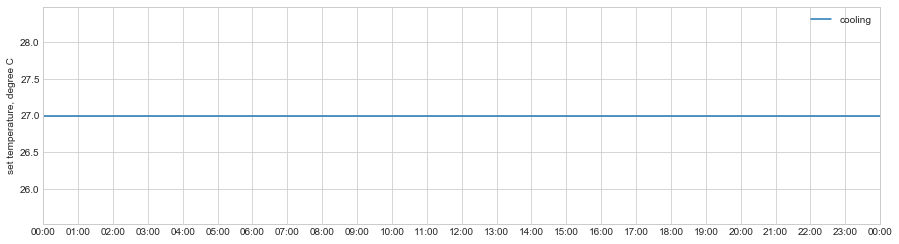

In [28]:
ac.draw_graph(y_title='set temperature, degree C', ys=[(theta_ac_c, 'cooling')], op='raw', display_date=cday)

# ダクト

## ダクト損失

ダクト $i$ の線熱損失係数 $\psi_i$ は、0.49 W/mK とする。

In [29]:
psi = cs.get_duct_linear_heat_loss_coefficient()
psi

0.49

## 標準住戸におけるダクト長さ

標準住戸における断熱区画内を通るダクト $i$ の長さ $l_{duct,in,R,i}$ 、標準住戸における断熱区画外を通るダクト $i$ の長さ $l_{duct,ex,R,i}$ 及び標準住戸におけるダクト $i$ の長さ $l_{duct,R,i}$ は下表の値とする。

| ダクトの長さ, m | 断熱区画1 | 断熱区画2 | 断熱区画3 | 断熱区画4 | 断熱区画5 |
| --- | --- | --- | --- | --- | --- |
| 断熱区画内 | 25.6 | 8.6 | 0.0 | 0.0 | 0.0 |
| 断熱区画外 | 0.0 | 0.0 | 10.2 | 11.8 | 8.1 |
| 合計 | 25.6 | 8.6 | 10.2 | 11.8 | 8.1 |

In [30]:
l_duct_in_r, l_duct_ex_r, l_duct_r = cs.get_standard_house_duct_length()

In [31]:
l_duct_in_r

array([25.6,  8.6,  0. ,  0. ,  0. ])

In [32]:
l_duct_ex_r

array([ 0. ,  0. , 10.2, 11.8,  8.1])

In [33]:
l_duct_r

array([25.6,  8.6, 10.2, 11.8,  8.1])

## 当該住戸のダクト長さ（合計）

ダクト $i$ の長さ $l_{duct,i}$ は次式により表される。

$$ l_{duct,i} = l_{duct,R,i} \sqrt{ \frac{A_A}{A_{A,R}} } $$

$l_{duct,i}$：ダクト$i$の長さ, m  
$l_{duct,R,i}$：標準住戸におけるダクト $i$ の長さ, m  
$A_A$：床面積の合計, m<sup>2</sup>  
$A_{A,R}$：標準住戸の床面積の合計, m  

In [34]:
l_duct = cs.get_duct_length(l_duct_r=l_duct_r, a_a=case['a_a'])
l_duct

array([25.6,  8.6, 10.2, 11.8,  8.1])

### 床面積の合計とダクト長さの関係

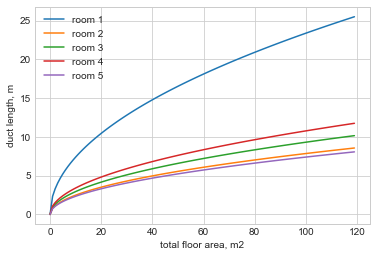

In [35]:
xs = np.arange(120)

def get_duct_length_each_room(room_number):
    return [cs.get_duct_length(l_duct_r=l_duct_r, a_a=x)[room_number] for x in xs]

plt.style.use('seaborn-whitegrid')

fig = plt.figure()

ax = fig.subplots()

ax.plot(xs, get_duct_length_each_room(0), label='room 1')
ax.plot(xs, get_duct_length_each_room(1), label='room 2')
ax.plot(xs, get_duct_length_each_room(2), label='room 3')
ax.plot(xs, get_duct_length_each_room(3), label='room 4')
ax.plot(xs, get_duct_length_each_room(4), label='room 5')

ax.set_xlabel('total floor area, m2')
ax.set_ylabel('duct length, m')

plt.legend()
plt.show()

## 小屋裏温度

暖房時

$$\theta_{attic,H,d,t} = \theta_{SAT,d,t} H + \theta_{ac,H} ( 1 - H )$$

冷房時

$$\theta_{attic,C,d,t} = \theta_{SAT,d,t} H + \theta_{ac,C} ( 1 - H )$$

$\theta_{attic,H,d,t}$：日付 $d$ の時刻 $t$ における暖房時の小屋裏の温度, degree C  
$\theta_{attic,C,d,t}$：日付 $d$ の時刻 $t$ における冷房時の小屋裏の温度, degree C  
$\theta_{SAT,d,t}$：日付 $d$ の時刻 $t$ における水平面における等価外気温度, degree C  
$H$：温度差係数  
$\theta_{ac,H}$：暖房時の暖冷房区画の温度, degree C  
$\theta_{ac,C}$：冷房時の暖冷房区画の温度, degree C  

In [36]:
theta_attic_h = cs.get_attic_temperature_for_heating(theta_sat, theta_ac_h, 1.0)
theta_attic_c = cs.get_attic_temperature_for_cooling(theta_sat, theta_ac_c, 1.0)

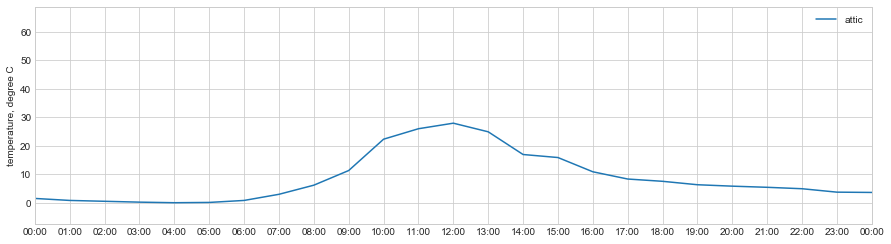

In [37]:
ac.draw_graph(y_title='temperature, degree C', ys=[(theta_attic_h, 'attic')], op='raw', display_date=hday)

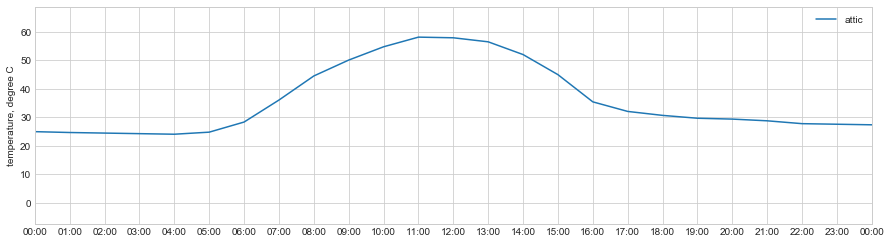

In [38]:
ac.draw_graph(y_title='temperature, degree C', ys=[(theta_attic_c, 'attic')], op='raw', display_date=cday)

## ダクト周囲空気温度

日付 $d$ の時刻 $t$ におけるダクト $i$ の周囲の空気温度 $\theta_{sur,d,t,i}$ はダクトの全部または一部が断熱区画外にある場合は下式によるものとし、それ意外の場合で暖房時は暖房時の暖冷房区画の温度 $\theta_{ac,H}$、冷房時は冷房時の冷房空間の温度 $\theta_{ac,C}$ に等しいとする。

暖房時

$$ \theta_{sur,H,d,t,i} = \frac{ l_{duct,in,R,i} \theta_{ac,H} + l_{duct,ex,R,i} \theta_{attic,d,t} }{ l_{duct,in,R,i} + l_{duct,ex,R,i} } $$

暖房時

$$ \theta_{sur,C,d,t,i} = \frac{ l_{duct,in,R,i} \theta_{ac,C} + l_{duct,ex,R,i} \theta_{attic,d,t} }{ l_{duct,in,R,i} + l_{duct,ex,R,i} } $$

$\theta_{sur,H,d,t,i}$：日付 $d$ の時刻 $t$ における暖房時のダクト $i$ の周囲の空気温度, degree C  
$\theta_{sur,C,d,t,i}$：日付dの時刻tにおける冷房時のダクトiの周囲の空気温度, degree C  
$\theta_{ac,H}$：暖房時の暖冷房区画の温度, degree C  
$\theta_{ac,C}$：冷房時の暖冷房区画の温度, degree C  
$l_{duct,in,R,i}$：標準住戸における断熱区画内を通るダクトiの長さ, m  
$l_{duct,ex,R,i}$：標準住戸における断熱区画外を通るダクトiの長さ, m  
$\theta_{attic,d,t}$：日付dの時刻tにおける小屋裏の温度, degree C  

In [39]:
theta_sur_h = cs.get_duct_ambient_air_temperature_for_heating(
    case['is_duct_insulated'], l_duct_in_r, l_duct_ex_r, theta_ac_h, theta_attic_h)
theta_sur_c = cs.get_duct_ambient_air_temperature_for_cooling(
    case['is_duct_insulated'], l_duct_in_r, l_duct_ex_r, theta_ac_c, theta_attic_c)

### ダクトが全て断熱区画内の場合のサンプル

In [40]:
theta_sur_h_sample_insulated = cs.get_duct_ambient_air_temperature_for_heating(
    True, l_duct_in_r, l_duct_ex_r, theta_ac_h, theta_attic_h)
theta_sur_c_sample_insulated = cs.get_duct_ambient_air_temperature_for_cooling(
    True, l_duct_in_r, l_duct_ex_r, theta_ac_c, theta_attic_c)

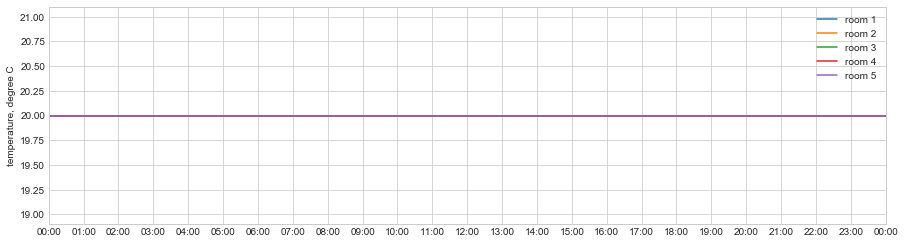

In [41]:
ac.draw_graph(y_title='temperature, degree C',
              ys=[(theta_sur_h_sample_insulated[0], 'room 1'),
                  (theta_sur_h_sample_insulated[1], 'room 2'),
                  (theta_sur_h_sample_insulated[2], 'room 3'),
                  (theta_sur_h_sample_insulated[3], 'room 4'),
                  (theta_sur_h_sample_insulated[4], 'room 5')], op='raw', display_date=hday)

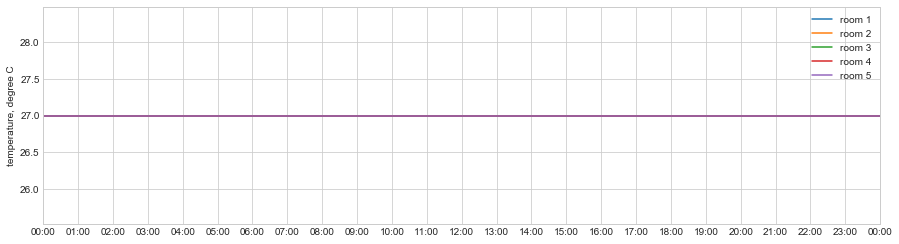

In [42]:
ac.draw_graph(y_title='temperature, degree C',
              ys=[(theta_sur_c_sample_insulated[0], 'room 1'),
                  (theta_sur_c_sample_insulated[1], 'room 2'),
                  (theta_sur_c_sample_insulated[2], 'room 3'),
                  (theta_sur_c_sample_insulated[3], 'room 4'),
                  (theta_sur_c_sample_insulated[4], 'room 5')], op='raw', display_date=cday)

### ダクトが全て断熱区画内ではない場合のサンプル

In [43]:
theta_sur_h_sample_not_insulated = cs.get_duct_ambient_air_temperature_for_heating(
    False, l_duct_in_r, l_duct_ex_r, theta_ac_h, theta_attic_h)
theta_sur_c_sample_not_insulated = cs.get_duct_ambient_air_temperature_for_cooling(
    False, l_duct_in_r, l_duct_ex_r, theta_ac_c, theta_attic_c)

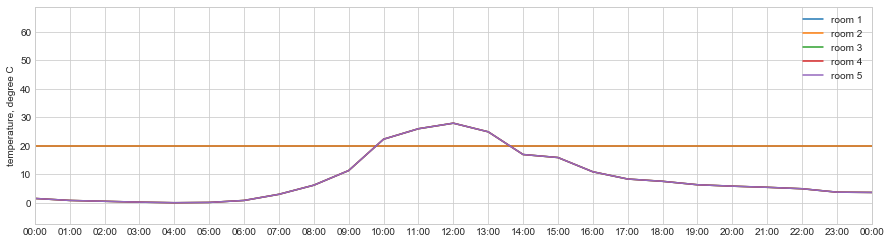

In [44]:
ac.draw_graph(y_title='temperature, degree C',
              ys=[(theta_sur_h_sample_not_insulated[0], 'room 1'),
                  (theta_sur_h_sample_not_insulated[1], 'room 2'),
                  (theta_sur_h_sample_not_insulated[2], 'room 3'),
                  (theta_sur_h_sample_not_insulated[3], 'room 4'),
                  (theta_sur_h_sample_not_insulated[4], 'room 5')], op='raw', display_date=hday)

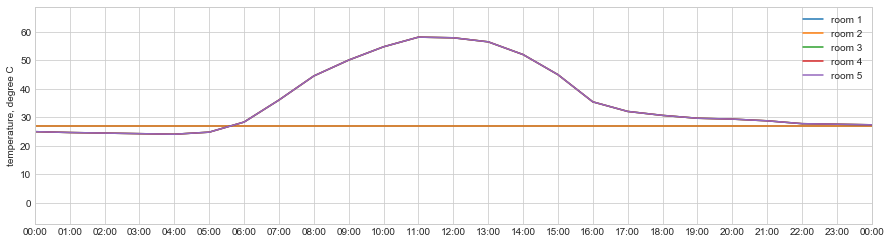

In [45]:
ac.draw_graph(y_title='temperature, degree C',
              ys=[(theta_sur_c_sample_not_insulated[0], 'room 1'),
                  (theta_sur_c_sample_not_insulated[1], 'room 2'),
                  (theta_sur_c_sample_not_insulated[2], 'room 3'),
                  (theta_sur_c_sample_not_insulated[3], 'room 4'),
                  (theta_sur_c_sample_not_insulated[4], 'room 5')], op='raw', display_date=cday)

# 機械換気量

$$V_{vent,i} = V_{vent,R,i} \frac{ A_{HCZ,i} }{ A_{HCZ,R,i} } $$

$V_{vent,i}$：暖冷房区画 $i$ の機械換気量, m<sup>3</sup>/h  
$V_{vent,R,i}$：標準住戸における暖冷房区画 $i$ の機械換気量, m<sup>3</sup>/h  
$A_{HCZ,i}$：暖冷房区画 $i$ の床面積, m<sup>2</sup>  
$A_{HCZ,R,i}$：標準住戸における暖冷房区画 $i$ の床面積, m<sup>2</sup>  

標準住戸における暖冷房区画 $i$ の機械換気量 $V_{vent,R,i}$ は下表で与えられる。

| 空間番号 | 標準住戸における暖冷房区画iの機械換気量 |
| --- | --- |
| 1 | 60.0 |
| 2 | 20.0 |
| 3 | 40.0 |
| 4 | 20.0 |
| 5 | 20.0 |

In [46]:
v_vent = cs.get_mechanical_ventilation(a_hcz_r, a_hcz)
v_vent

array([60., 20., 40., 20., 20.])